### A whirlwind tour of earthaccess

Login to the system with your credentials and import a bunch of stuff.

In [16]:
import earthaccess
assert(earthaccess.login(strategy="netrc").authenticated)

In [17]:
import xarray as xr
import rioxarray
import rasterio
import numpy as np
from matplotlib import pyplot as plt
from pyproj import Transformer

### Define search area, search data

In [18]:
mrnp_bounds = -121.945496,46.756798,-121.522522,47.002734

daymet_granules = earthaccess.search_data(
    short_name="Daymet_Annual_V4R1_2130",
    bounding_box=mrnp_bounds,
    temporal=("2000-01-01", "2010-01-01")
)

In [19]:
len(daymet_granules)

110

In [20]:
prcp_granules = list(filter(
    lambda x: "prcp" in x["meta"]["native-id"] and x["meta"]["native-id"].endswith("nc"),
    daymet_granules
))

In [21]:
len(prcp_granules)

11

In [22]:
prcp_granules[0]

Collection: {'ShortName': 'Daymet_Annual_V4R1_2130', 'Version': '4.1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -178.133, 'EastBoundingCoordinate': -53.0567, 'NorthBoundingCoordinate': 82.9143, 'SouthBoundingCoordinate': 14.0749}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2000-01-01T00:00:00.000Z', 'EndingDateTime': '2000-12-30T23:59:59.000Z'}}
Size(MB): 442.471183
Data: ['https://data.ornldaac.earthdata.nasa.gov/protected/daymet/Daymet_Annual_V4R1/data/daymet_v4_prcp_annttl_na_2000.nc', 'https://data.ornldaac.earthdata.nasa.gov/public/daymet/Daymet_Annual_V4R1/data/daymet_v4_prcp_annttl_na_2000.nc.sha256']

In [23]:
opened = earthaccess.open(prcp_granules)
opened[0]

QUEUEING TASKS | :   0%|          | 0/11 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/11 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/11 [00:00<?, ?it/s]

<File-like object S3FileSystem, ornl-cumulus-prod-protected/daymet/Daymet_Annual_V4R1/data/daymet_v4_prcp_annttl_na_2000.nc>

### Open the data

In [24]:
%%time
mydaymet = xr.open_mfdataset(opened, compat="override", coords="minimal", decode_coords="all")
mydaymet

CPU times: user 1.34 s, sys: 292 ms, total: 1.63 s
Wall time: 11.3 s


<xarray.Dataset> Size: 3GB
Dimensions:                  (time: 11, y: 8075, x: 7814, nv: 2)
Coordinates:
    time_bnds                (time, nv) datetime64[ns] 176B dask.array<chunksize=(1, 2), meta=np.ndarray>
    lambert_conformal_conic  int16 2B ...
    lat                      (y, x) float32 252MB dask.array<chunksize=(1010, 977), meta=np.ndarray>
    lon                      (y, x) float32 252MB dask.array<chunksize=(1010, 977), meta=np.ndarray>
  * time                     (time) datetime64[ns] 88B 2000-07-01T12:00:00 .....
  * x                        (x) float32 31kB -4.56e+06 -4.559e+06 ... 3.253e+06
  * y                        (y) float32 32kB 4.984e+06 4.983e+06 ... -3.09e+06
Dimensions without coordinates: nv
Data variables:
    prcp                     (time, y, x) float32 3GB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    start_year:        2000
    source:            Daymet Software Version 4.0
    Version_software:  Daymet Software Version 4.0
    Version_data:      Daymet Data Version 4.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...

### Clip

In [25]:
lcc_proj = "+proj=lcc +lon_0=-100 +lat_0=42.5 +lat_1=25 +lat_2=60 +ellps=GRS80"
tformer = Transformer.from_crs("EPSG:4326", mydaymet.rio.crs, always_xy=True)
xmin, ymin, xmax, ymax = tformer.transform_bounds(*mrnp_bounds)

In [26]:
mydaymet_clip = mydaymet.sel(x=slice(xmin, xmax), y=slice(ymax, ymin))
mydaymet_clip

<xarray.Dataset> Size: 62kB
Dimensions:                  (time: 11, y: 33, x: 36, nv: 2)
Coordinates:
    time_bnds                (time, nv) datetime64[ns] 176B dask.array<chunksize=(1, 2), meta=np.ndarray>
    lambert_conformal_conic  int16 2B ...
    lat                      (y, x) float32 5kB dask.array<chunksize=(33, 36), meta=np.ndarray>
    lon                      (y, x) float32 5kB dask.array<chunksize=(33, 36), meta=np.ndarray>
  * time                     (time) datetime64[ns] 88B 2000-07-01T12:00:00 .....
  * x                        (x) float32 144B -1.582e+06 ... -1.547e+06
  * y                        (y) float32 132B 6.85e+05 6.84e+05 ... 6.53e+05
Dimensions without coordinates: nv
Data variables:
    prcp                     (time, y, x) float32 52kB dask.array<chunksize=(1, 33, 22), meta=np.ndarray>
Attributes:
    start_year:        2000
    source:            Daymet Software Version 4.0
    Version_software:  Daymet Software Version 4.0
    Version_data:      Daymet Data Version 4.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...

### Plotting

In [27]:
%%time
prcp_sum = mydaymet_clip.sum(dim="time").compute()

CPU times: user 1.38 s, sys: 364 ms, total: 1.75 s
Wall time: 9.55 s


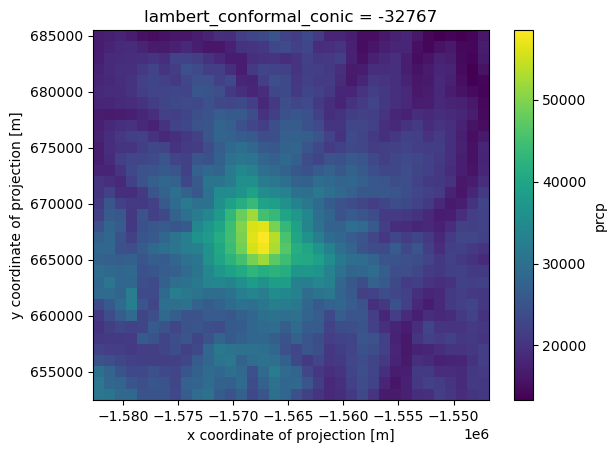

In [28]:
prcp_sum.prcp.plot()

In [29]:
prcp_reproj = prcp_sum.drop_vars(["lat", "lon"])\
    .rio.write_crs(mydaymet.rio.crs)\
    .rio.reproject("EPSG:4326")

In [30]:
import folium

def make_folium_plot(arr: xr.DataArray, cmap: str="cubehelix", **kwargs):
    data2plot = np.flipud(arr.values.squeeze().astype(np.float64))
    normed_data = (data2plot - np.nanmin(data2plot)) / (np.nanmax(data2plot) - np.nanmin(data2plot))

    # Color the data
    cm = plt.get_cmap(cmap)
    colored_data = cm(normed_data)

    xmin, ymin, xmax, ymax = arr.rio.bounds()

    m = folium.Map(location=[arr.y.mean(), arr.x.mean()], **kwargs)
    folium.raster_layers.ImageOverlay(
        colored_data,
        [[ymin, xmin], [ymax, xmax]],
        mercator_project=True,
        opacity=0.5
    ).add_to(m)
    
    folium.LatLngPopup().add_to(m)
    folium.LayerControl().add_to(m)

    return m

In [15]:
make_folium_plot(prcp_reproj.prcp, cmap="viridis")